In [ ]:
!pip install torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator, Vocab
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from wordcloud import WordCloud

In [ ]:
# Download dataset from Kaggle
!pip install kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 51% 13.0M/25.7M [00:00<00:00, 133MB/s]
100% 25.7M/25.7M [00:00<00:00, 188MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
df = pd.read_csv("/content/imdb-dataset-of-50k-movie-reviews.zip")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Convert sentiment to binary
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

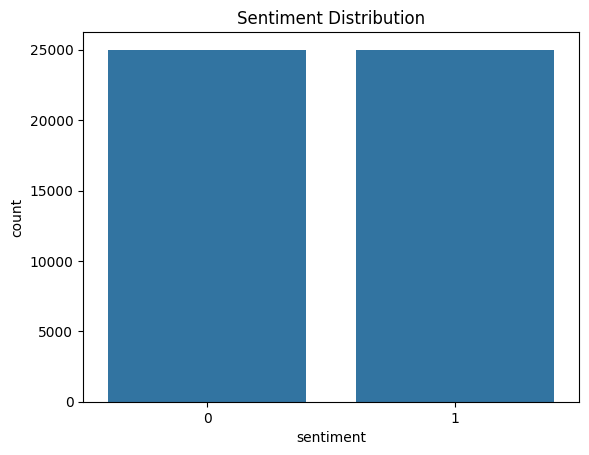

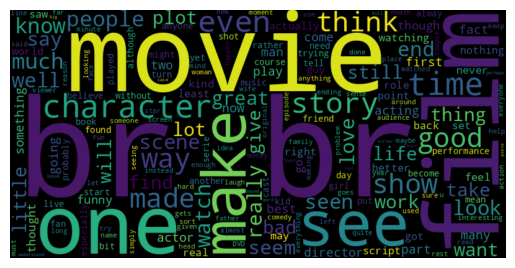

In [ ]:
# Data visualization
sns.countplot(x=df["sentiment"])
plt.title("Sentiment Distribution")
plt.show()

wordcloud = WordCloud(width=800, height=400).generate(" ".join(df["review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import nltk

# Download missing resources
nltk.download('punkt')
nltk.download('stopwords')

# Force NLTK to update its tokenizer
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import spacy
import re

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.lemma_ for token in doc if not token.is_stop]  # Lemmatization & stopword removal
    return tokens  # Returns a list of clean words

# Apply preprocessing
df["cleaned_review"] = df["review"].apply(clean_text)


In [ ]:
# Manually build vocabulary
word_counter = Counter()
for tokens in df["cleaned_review"]:
    word_counter.update(tokens)

# Assign an index to each word
vocab = {"<PAD>": 0, "<UNK>": 1}  # Start with special tokens
for idx, (word, _) in enumerate(word_counter.items(), start=2):
    vocab[word] = idx

# Convert reviews to sequences of word indices
def encode_text(tokens, vocab, max_length=100):
    encoded = [vocab.get(token, vocab["<UNK>"]) for token in tokens]  # Convert words to indices
    if len(encoded) < max_length:
        encoded += [vocab["<PAD>"]] * (max_length - len(encoded))  # Padding
    else:
        encoded = encoded[:max_length]  # Truncate
    return encoded

df["encoded_review"] = df["cleaned_review"].apply(lambda tokens: encode_text(tokens, vocab))


In [ ]:
# Dataset class
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.labels[index], dtype=torch.float32)


In [ ]:
# Split data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = IMDBDataset(train_data["encoded_review"].tolist(), train_data["sentiment"].tolist())
test_dataset = IMDBDataset(test_data["encoded_review"].tolist(), test_data["sentiment"].tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Define Model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<PAD>"])
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        return self.sigmoid(self.fc(hidden.squeeze(0)))

model = SentimentRNN(len(vocab))


In [ ]:
# Training
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs).squeeze(1)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 0.6938419107437134
Epoch 2, Loss: 0.6807201607227326
Epoch 3, Loss: 0.658913563299179
Epoch 4, Loss: 0.618261931014061
Epoch 5, Loss: 0.6402430613279343


In [ ]:
# Evaluation
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs).squeeze(1)
        predictions = (output >= 0.5).float()
        y_true.extend(labels.tolist())
        y_pred.extend(predictions.tolist())

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


Accuracy: 0.6944
Precision: 0.7065
Recall: 0.6731
F1 Score: 0.6894


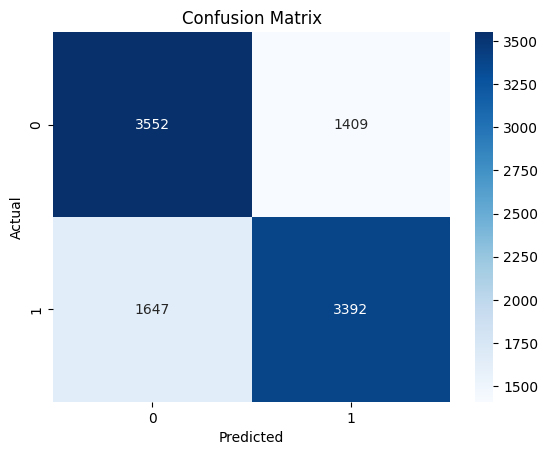

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Predict Function
def predict_sentiment(text):
    tokens = clean_text(text)
    encoded = encode_text(tokens, vocab)
    with torch.no_grad():
        output = model(torch.tensor([encoded]))
    return "Positive" if output.item() >= 0.5 else "Negative"

# Example
print(predict_sentiment("This movie was absolutely fantastic!"))
print(predict_sentiment("I hated this movie. It was terrible."))

Negative
Negative
